In [9]:
from bids import BIDSLayout
import os

# Define your root directory
data_path = '/Volumes/T9/ds001486/derivatives/fmriprep'

# Initialize the layout
layout = BIDSLayout(data_path, validate=False, derivatives=False)

# Get all preprocessed BOLD files for the math task
# This returns a list of objects containing path info
bold_files = layout.get(suffix='bold', 
                        extension='nii.gz', 
                        desc='preproc', 
                        return_type='file')

In [ ]:
import numpy as np
import os
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn import datasets

# --- 1. Your Defined Groups ---
mld_subs = ['059', '065', '067', '069', '071', '075', '076', '077', 
            '078', '083', '088', '095', '096', '103', '106']

td_subs = ['090', '036', '013', '008', '057', '070', '023', '024', 
           '053', '044', '034', '060', '007', '027', '010']

# --- 2. Setup Atlas and Masker ---
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=7)

masker = NiftiLabelsMasker(labels_img=atlas.maps, standardize=True, memory=None)
conn_measure = ConnectivityMeasure(kind='correlation', vectorize=True, discard_diagonal=True)



[fetch_atlas_schaefer_2018] Dataset found in /Users/jchong058/nilearn_data/schaefer_2018


In [11]:
import pandas as pd
import numpy as np
import os

X = []          
y_group = []    
y_task = []     # 1 for Mult, 0 for Sub
groups = []     

print("🚀 Starting feature extraction (Math only)...")

# Output folder on your Desktop to avoid read-only errors
output_dir = os.path.expanduser('~/Desktop/math_results')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for bold_path in bold_files:
    filename = os.path.basename(bold_path)
    
    # 1. Precise Task Filtering
    # We explicitly check for Mult and Sub to avoid labeling Rhyming/Num as Sub
    if 'task-Mult' in filename:
        current_task = 1
    elif 'task-Sub' in filename:
        current_task = 0
    else:
        # Skips Rhyming, Num, or any other non-math tasks
        continue 

    # 2. Confound Path Construction
    parts = filename.split('_')
    essential_parts = [p for p in parts if any(x in p for x in ['sub-', 'ses-', 'task-', 'run-'])]
    confound_name = "_".join(essential_parts) + "_desc-confounds_timeseries.tsv"
    confound_path = os.path.join(os.path.dirname(bold_path), confound_name)

    if not os.path.exists(confound_path):
        continue

    # 3. Subject ID and Grouping (MLD vs TD)
    sub_id = filename.split('_')[0].split('-')[1] 
    group_label = 1 if sub_id in mld_subs else 0 #
    
    try:
        # Load and clean confounds (Handles NaNs and non-numeric columns)
        df = pd.read_csv(confound_path, sep='\t')
        df_numeric = df.select_dtypes(include=[np.number])
        df_clean = df_numeric.fillna(0).dropna(axis=1, how='all')
        
        # Extraction with standardized sample scaling
        masker.set_params(standardize='zscore_sample')
        conn_measure.set_params(standardize='zscore_sample') 
        
        time_series = masker.fit_transform(bold_path, confounds=df_clean)
        
        # Quality Check for Signal
        if np.any(np.isnan(time_series)) or np.any(np.isinf(time_series)):
            print(f"⚠️ {sub_id} has bad signal (NaNs/Infs). Skipping.")
            continue
            
        correlation_vector = conn_measure.fit_transform([time_series])[0]
        
        # --- SUCCESS ---
        X.append(correlation_vector)
        y_group.append(group_label)
        y_task.append(current_task) # Store 1 for Mult, 0 for Sub
        groups.append(sub_id) 
        task_name = "Mult" if current_task == 1 else "Sub"
        print(f"✅ {sub_id} | {task_name} added successfully.")
        
    except Exception as e:
        print(f"❌ Error on {sub_id}: {e}")

# --- FINAL SAVE ---
# Saving all 4 arrays to your Desktop
X = np.array(X)
y = np.array(y_group)
yt = np.array(y_task)
g = np.array(groups)

np.save(os.path.join(output_dir, 'X_features.npy'), X)
np.save(os.path.join(output_dir, 'y_labels.npy'), y)
np.save(os.path.join(output_dir, 'y_tasks.npy'), yt) # New file for task labels
np.save(os.path.join(output_dir, 'subject_groups.npy'), g)

print(f"\n🎉 DONE! Saved {len(y)} samples to {output_dir}")

🚀 Starting feature extraction (Math only)...


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 007 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 007 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 007 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 007 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 007 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 007 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 007 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 007 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 008 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 008 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 008 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 008 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 008 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 008 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 008 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 008 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 010 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 010 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 010 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 010 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 010 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 010 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 010 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 010 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 013 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 013 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 013 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 013 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 013 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 013 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 013 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 013 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 023 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 023 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 023 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 023 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 023 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 023 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 023 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 023 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 024 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 024 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 024 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 024 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 024 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 024 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 024 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 024 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 027 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 027 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 027 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 027 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 027 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 027 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 027 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 027 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 034 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 034 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 034 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 034 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 034 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 034 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 034 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 034 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 036 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 036 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 036 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 036 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 036 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 036 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 036 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 036 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 044 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 044 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 044 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 044 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 044 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 044 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 044 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 044 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 053 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 053 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 053 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 053 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 053 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 053 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 053 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 053 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 057 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 057 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 057 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 057 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 057 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 057 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 057 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 057 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 059 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 059 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 059 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 059 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 059 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 059 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 059 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 059 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 060 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 060 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 060 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 060 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 060 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 060 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 060 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 060 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 065 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 065 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 065 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 065 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 065 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 065 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 065 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 065 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 067 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 067 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 067 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 067 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 067 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 067 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 067 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 067 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 069 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 069 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 069 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 069 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 069 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 069 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 069 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 069 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 070 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 070 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 070 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 070 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 070 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 070 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 070 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 070 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 071 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 071 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 071 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 071 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 071 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 071 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 071 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 071 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 075 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 075 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 075 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 075 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 075 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 075 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 075 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 075 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 076 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 076 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 076 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 076 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 076 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 076 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 076 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 076 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 077 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 077 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 077 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 077 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 077 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 077 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 077 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 077 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 078 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 078 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 078 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 078 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 078 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 078 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 078 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 078 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 083 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 083 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 083 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 083 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 083 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 083 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 083 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 083 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 088 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 088 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 088 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 088 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 088 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 088 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 088 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 088 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 090 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 090 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 090 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 090 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 090 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 090 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 090 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 090 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 095 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 095 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 095 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 095 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 095 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 095 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 095 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 095 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 096 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 096 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 096 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 096 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 096 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 096 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 096 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 096 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 103 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 103 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 103 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 103 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 103 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 103 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 103 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 103 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 106 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 106 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 106 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 106 | Sub added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 106 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 106 | Mult added successfully.


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)


✅ 106 | Sub added successfully.
✅ 106 | Sub added successfully.

🎉 DONE! Saved 240 samples to /Users/jchong058/Desktop/math_results


/var/folders/nb/t9_yz5pn7ql2nyvm9cy5kngc0000gn/T/ipykernel_27523/157699266.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  time_series = masker.fit_transform(bold_path, confounds=df_clean)



✅ Multiplication (Averaged) Accuracy: 56.67%
              precision    recall  f1-score   support

          TD       0.56      0.60      0.58        15
         MLD       0.57      0.53      0.55        15

    accuracy                           0.57        30
   macro avg       0.57      0.57      0.57        30
weighted avg       0.57      0.57      0.57        30


✅ Subtraction (Averaged) Accuracy: 20.00%
              precision    recall  f1-score   support

          TD       0.26      0.33      0.29        15
         MLD       0.09      0.07      0.08        15

    accuracy                           0.20        30
   macro avg       0.18      0.20      0.19        30
weighted avg       0.18      0.20      0.19        30



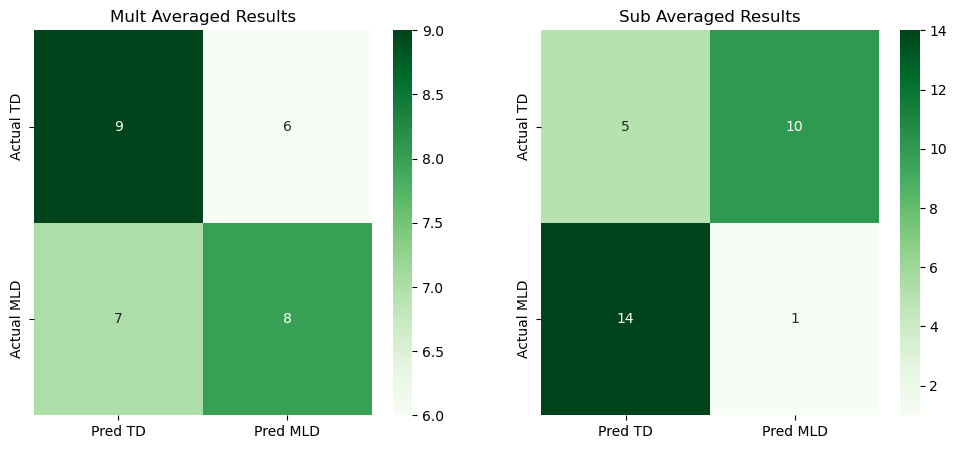

In [19]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif

# 1. Load your 4 data files from Desktop
output_dir = os.path.expanduser('~/Desktop/math_results')
X = np.load(os.path.join(output_dir, 'X_features.npy'))
y_group = np.load(os.path.join(output_dir, 'y_labels.npy'))
y_task = np.load(os.path.join(output_dir, 'y_tasks.npy'))
groups = np.load(os.path.join(output_dir, 'subject_groups.npy'))

def average_and_classify(task_id, task_name):
    # Filter for the specific task (Mult=1, Sub=0)
    X_t = X[y_task == task_id]
    y_t = y_group[y_task == task_id]
    g_t = groups[y_task == task_id]
    
    # --- SUBJECT AVERAGING LOGIC ---
    X_avg, y_avg = [], []
    unique_subs = np.unique(g_t)
    
    for sub in unique_subs:
        sub_indices = np.where(g_t == sub)[0]
        # Average all runs (T1, T2, Run-01, etc.) for this specific task
        X_avg.append(np.mean(X_t[sub_indices], axis=0))
        y_avg.append(y_t[sub_indices[0]])
        
    X_avg = np.array(X_avg)
    y_avg = np.array(y_avg)
    
    # --- SVM CLASSIFICATION ---
    # With only 30 samples, we use Leave-One-Out (LOO)
    pipeline = Pipeline([
        ('feature_selection', SelectKBest(f_classif, k=50)),
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='linear', C=1.0))
    ])
    
    loo = LeaveOneOut()
    y_pred = []
    
    for train_idx, test_idx in loo.split(X_avg):
        pipeline.fit(X_avg[train_idx], y_avg[train_idx])
        y_pred.append(pipeline.predict(X_avg[test_idx])[0])
    
    acc = accuracy_score(y_avg, y_pred)
    print(f"\n✅ {task_name} (Averaged) Accuracy: {acc * 100:.2f}%")
    print(classification_report(y_avg, y_pred, target_names=['TD', 'MLD']))
    
    return y_avg, y_pred

# Run the Averaged SVMs
y_m_true, y_m_pred = average_and_classify(1, "Multiplication")
y_s_true, y_s_pred = average_and_classify(0, "Subtraction")

# 2. Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for i, (t, p, name) in enumerate([(y_m_true, y_m_pred, "Mult"), (y_s_true, y_s_pred, "Sub")]):
    cm = confusion_matrix(t, p)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=ax[i],
                xticklabels=['Pred TD', 'Pred MLD'], yticklabels=['Actual TD', 'Actual MLD'])
    ax[i].set_title(f"{name} Averaged Results")
plt.show()

In [22]:
from sklearn.feature_selection import SelectKBest, f_classif

# 1. Re-create the averaged Multiplication data for interpretation
X_m = X[y_task == 1]
y_m = y_group[y_task == 1]
g_m = groups[y_task == 1]

X_mult_avg, y_mult_avg = [], []
for sub in np.unique(g_m):
    idx = np.where(g_m == sub)[0]
    X_mult_avg.append(np.mean(X_m[idx], axis=0))
    y_mult_avg.append(y_m[idx[0]])

X_mult_avg = np.array(X_mult_avg)
y_mult_avg = np.array(y_mult_avg)

# 2. Define and Fit the Global Pipeline (Matching your names exactly)
global_pipeline = Pipeline([
    ('feature_selection', SelectKBest(f_classif, k=50)),
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', C=1.0))
])

global_pipeline.fit(X_mult_avg, y_mult_avg)

# 3. NOW you can find the 'feature_selection' step
support = global_pipeline.named_steps['feature_selection'].get_support()
feature_indices = np.where(support)[0]
weights = global_pipeline.named_steps['svm'].coef_[0]

# 4. Map to ROI pairs (Schaefer 400 uses upper triangle indices)
roi_indices = np.triu_indices(400, k=1)
roi_pairs = list(zip(roi_indices[0], roi_indices[1]))

# 5. Print the Top 10 strongest connections
print(f"{'Brain Connection':<55} | {'Weight':<10}")
print("-" * 70)

sorted_idx = np.argsort(np.abs(weights))[::-1]
labels = atlas.labels 

# Since labels are often 'bytes' in Python, let's clean them to strings
labels = [label.decode('utf-8') if isinstance(label, bytes) else label for label in labels]

for i in sorted_idx[:10]:
    feat_idx = feature_indices[i]
    roi_a, roi_b = roi_pairs[feat_idx]
    
    # Assuming 'labels' is your list of 400 Schaefer ROI names
    # e.g., '7_Networks_LH_Cont_Par_1'
    name_a = labels[roi_a] 
    name_b = labels[roi_b]
    
    print(f"{name_a[:25]} <-> {name_b[:25]:<25} | {weights[i]:.4f}")

Brain Connection                                        | Weight    
----------------------------------------------------------------------
7Networks_RH_SomMot_25 <-> 7Networks_RH_DorsAttn_Pos | 0.1967
7Networks_LH_DorsAttn_Pos <-> 7Networks_RH_Vis_14       | 0.1947
7Networks_RH_Vis_11 <-> 7Networks_RH_Default_PFCd | 0.1947
7Networks_LH_DorsAttn_Pos <-> 7Networks_RH_Vis_11       | 0.1867
7Networks_LH_Vis_16 <-> 7Networks_LH_DorsAttn_Pos | 0.1806
7Networks_LH_DorsAttn_Pos <-> 7Networks_RH_SalVentAttn_ | -0.1710
7Networks_LH_DorsAttn_Pos <-> 7Networks_RH_SomMot_18    | 0.1691
7Networks_RH_Vis_17 <-> 7Networks_RH_Default_PFCd | 0.1674
7Networks_LH_Limbic_TempP <-> 7Networks_RH_Vis_10       | 0.1562
7Networks_RH_SalVentAttn_ <-> 7Networks_RH_Default_PFCd | 0.1457
